# Run atom model

In [ ]:
import os
import numpy as np
from pyatom import Model

import sys
sys.path.append('../reconstruction')
from reconstruct_atom_data import reconstruct_temperature

model = Model()
times=range(0,6,5)

for t in range(len(times)):
    model.run_atm( times[t], './output/', './config_atm.xml' )
    if t<len(times)-1:
        reconstruct_temperature(times[t], times[t+1])

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import numpy as np

def plot_xyz(topo, series, title, lats, lons, no_shift=False):

    plt.figure(figsize=(15, 8))

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

    old_lons = lons
    lons, topo = m.shiftdata(old_lons, datain = topo, lon_0=0)
    lons, series = m.shiftdata(old_lons, datain = series, lon_0=0)

    xi, yi = m(lons, lats)
    
    cs = m.scatter(xi, yi, marker='.', c=series, alpha=0.5, lw=0)#, vmin=-40, vmax=40)

    # Add Grid Lines
    m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

    
    if time == 0:
        m.drawcoastlines()   
        #m.barbs(xi[points], yi[points], adata[points, 4], adata[points, 3], pivot='middle', barbcolor='#333333')

    else:  
        #m.drawcoastlines()
        con_topo = m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                        colors ='k', linewidths= 0.3 )
        
    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    # cbar.set_label(tmax_units)

    # Add Title
    plt.title(title)
    #print plt.title(title)

    plt.show()

'''
adata = np.loadtxt('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(time), skiprows=1)
atm_header = ['lats (deg)', 'lons (deg)', 'topography', 'v-velocity (m/s)', 
              'w-velocity (m/s)', 'velocity-mag (m/s)', 'temperature (Celcius)', 
              'water_vapour (g/kg)', 'precipitation (mm/d)', 'precipitable_water (mm)']

alats = -(adata[:, 1] - 90.)
alons = adata[:, 0]
topo = adata[:, 2]
plot_xyz(topo, adata[:, 6],  'temperature  ATOM atmosphere at Ma={0}'.format(time), alats, alons)
'''

In [ ]:
import numpy as np

st = np.genfromtxt('../data/SurfaceTemperature_NASA.xyz')
adata = np.loadtxt('./output/[0Ma_Golonka.xyz]_PlotData_Atm.xyz', skiprows=1)
topo = adata[:, 2]
time=0
plot_xyz(topo, series=st[:, 2], title='Surface Temperature_NASA (Celsius) at Ma=0', lons=adata[:, 0], lats=-(adata[:, 1] - 90.))
plot_xyz(topo, series=adata[:, 6], title='Surface Temperature_NASA (Celsius) at Ma=0', lons=adata[:, 0], lats=-(adata[:, 1] - 90.))

for t in range(10,150,10):
    time=t
    adata = np.loadtxt('./output/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(t), skiprows=1)
    st = np.genfromtxt('./output/{0}Ma_SurfaceTemperature.xyz'.format(t))
    alats = -(adata[:, 1] - 90.)
    alons = adata[:, 0]
    topo = adata[:, 2]
    plot_xyz(topo, st[:, 2],  'Reconstructed temperature ATOM atmosphere at Ma={0}'.format(t), lons=st[:, 0], lats=st[:, 1])
    plot_xyz(topo, adata[:, 6],  'Output temperature ATOM atmosphere at Ma={0}'.format(t), alats, alons)
    

# inspect the temperature data before and after reconstruction

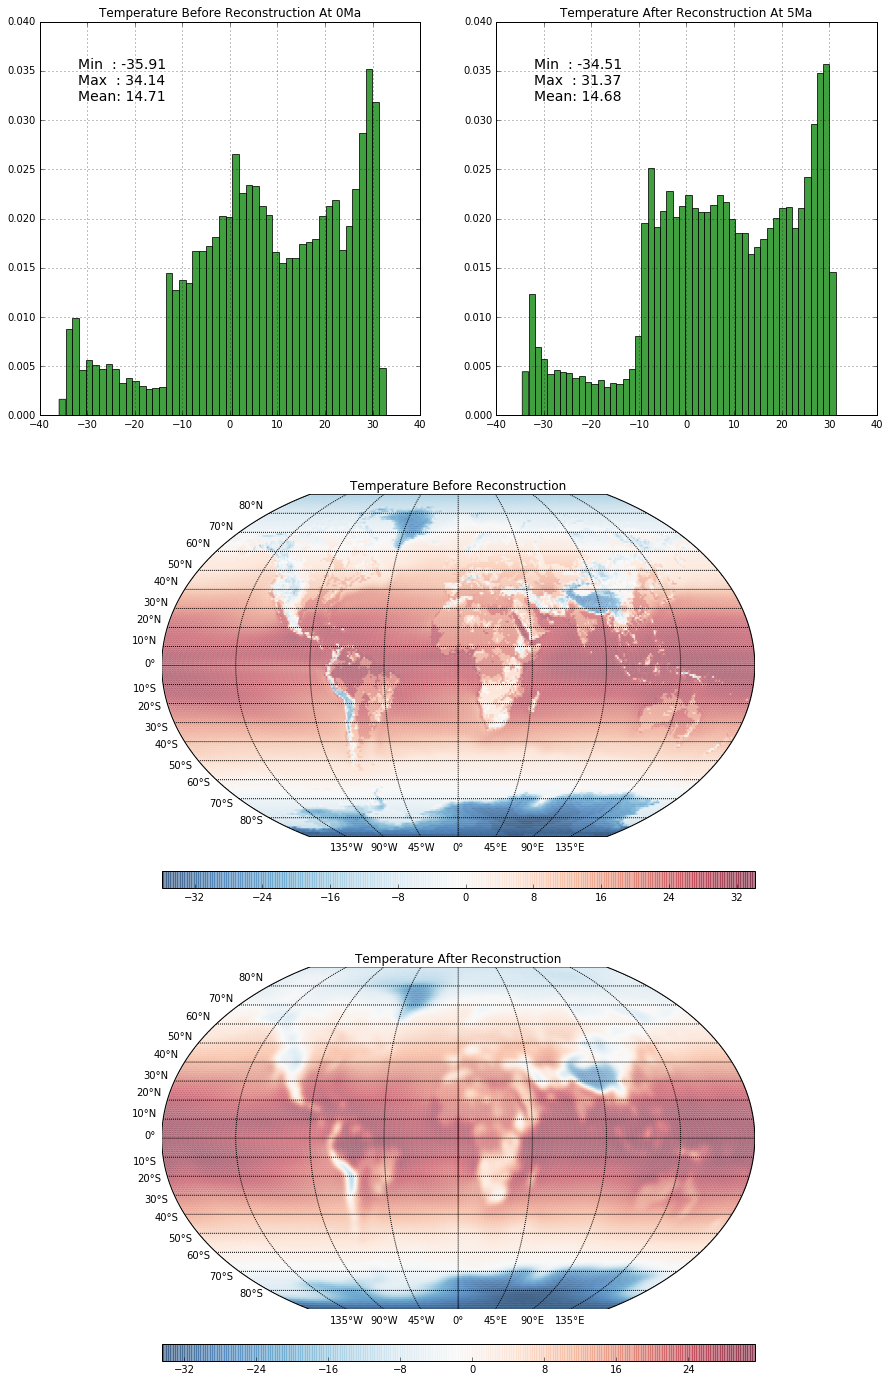

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

def calculate_spherical_mean(values, latitudes):
    lat_r=(np.absolute(latitudes))/90.0*np.pi/2
    lat_c= np.cos(np.absolute(lat_r))
    count=0
    for n,l in zip(values, lat_c):
        count+=n*l
    return count/np.sum(lat_c)

plt.figure(figsize=(15, 24))

#
# histgram for the data before reconstruction
#
plt.subplot2grid((3,2),(0,0))
adata = np.loadtxt('./output/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(0), skiprows=1)
data = adata[:,6]
data = data[~np.isnan(data)]
t_min = np.nanmin(data)
t_max = np.nanmax(data)

correct_lats = -(adata[:, 1] - 90.)

t_mean = calculate_spherical_mean(adata[:,6], correct_lats)
label_str = 'Min  : {0:.2f}\nMax  : {1:.2f}\nMean: {2:.2f}'.format(t_min, t_max, t_mean)
# the histogram of the data
n, bins, patches = plt.hist(data, 50, normed=1, facecolor='g', alpha=0.75)
plt.text(0.1, .8, label_str, fontsize=14, transform=plt.gca().transAxes)
#print plt.axis()
plt.title("Temperature Before Reconstruction At 0Ma")
plt.grid(True)
#plt.show()


#
# histgram for the data after reconstruction
#
plt.subplot2grid((3,2),(0,1))
all_data = np.genfromtxt('./output/{0}Ma_Reconstructed_Temperature.xyz'.format(5))
st = all_data[:,2]

t_min = np.nanmin(st)
t_max = np.nanmax(st)
t_mean = calculate_spherical_mean(st, all_data[:,1])
label_str = 'Min  : {0:.2f}\nMax  : {1:.2f}\nMean: {2:.2f}'.format(t_min, t_max, t_mean)

n, bins, patches = plt.hist(st, 50, normed=1, facecolor='g', alpha=0.75)
plt.text(0.1, .8, label_str, fontsize=14, transform=plt.gca().transAxes)
#print plt.axis()
plt.title("Temperature After Reconstruction At 5Ma")
plt.grid(True)
#plt.show() 


#
# Draw the temperature maps before and after reconstruction
#
plt.subplot2grid((3,2),(1,0),colspan=2)

#z = st - data
z = data

m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)    
xi, yi = m(all_data[:,0], all_data[:,1])

cs = m.scatter(xi, yi, c=z, marker='.',cmap='RdBu_r', alpha=0.5, lw=0 )

m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)
#m.drawcoastlines()   

cbar = m.colorbar(cs, location='bottom', pad="10%")
plt.title("Temperature Before Reconstruction")


plt.subplot2grid((3,2),(2,0),colspan=2)

#z = st - data
z = st

m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)    
xi, yi = m(all_data[:,0], all_data[:,1])

cs = m.scatter(xi, yi, c=z, marker='.',cmap='RdBu_r', alpha=0.5, lw=0 )

m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)
#m.drawcoastlines()   

cbar = m.colorbar(cs, location='bottom', pad="10%")
plt.title("Temperature After Reconstruction")

plt.show()


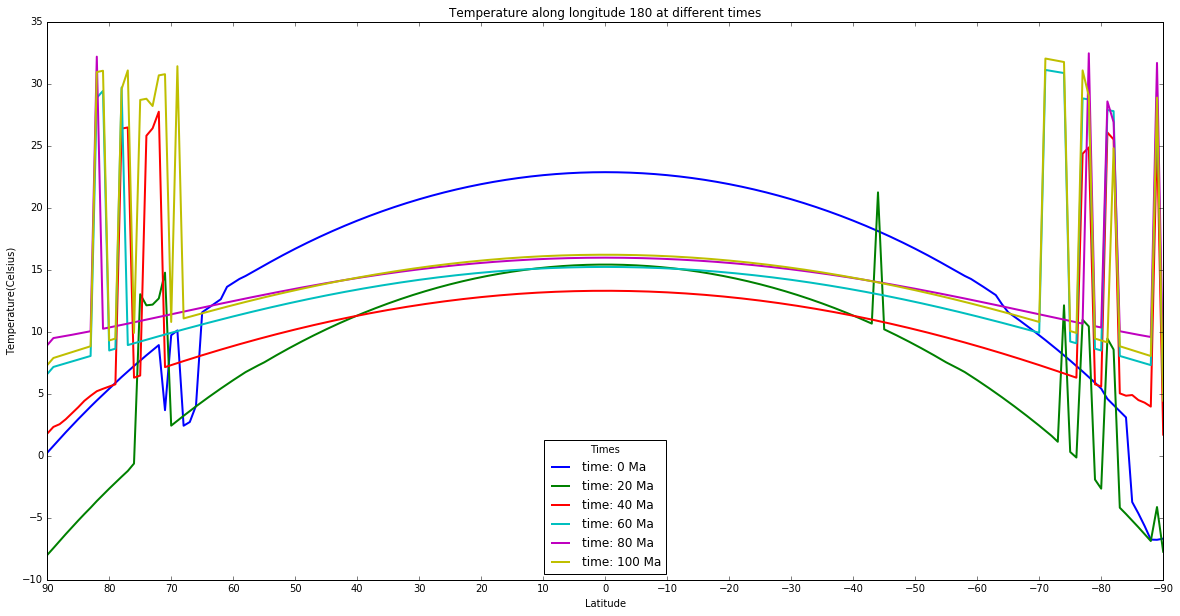

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.xlim(90, -90)
plt.xticks(range(90,-91,-10))
plt.title('Temperature along longitude 180 at different times')

x=range(90,-91,-1)

for time in range(0,101,20):
    adata = np.loadtxt('./output/[{}Ma_smooth.xyz]_PlotData_Atm.xyz'.format(time), skiprows=1)
    plt.plot(x, adata[:, 6].reshape((361,181))[180],  label='time: {} Ma'.format(time), linewidth=2)
    
plt.legend(title='Times', loc="lower center")
plt.xlabel('Latitude')
plt.ylabel('Temperature(Celsius)')
plt.savefig('./output/temperature_at_lon_180.png')
plt.show()
